In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, roc_auc_score

In [ ]:
df = pd.read_csv('course_lead_scoring.csv')
print(df.head())  

    lead_source    industry  number_of_courses_viewed  annual_income  \
0      paid_ads         NaN                         1        79450.0   
1  social_media      retail                         1        46992.0   
2        events  healthcare                         5        78796.0   
3      paid_ads      retail                         2        83843.0   
4      referral   education                         3        85012.0   

  employment_status       location  interaction_count  lead_score  converted  
0        unemployed  south_america                  4        0.94          1  
1          employed  south_america                  1        0.80          0  
2        unemployed      australia                  3        0.69          1  
3               NaN      australia                  1        0.87          0  
4     self_employed         europe                  3        0.62          1  


### In this dataset our desired target for classification task will be converted variable - has the client signed up to the platform or not.

### Data preparation
    * Check if the missing values are presented in the features.
    * If there are missing values:
    * For caterogiral features, replace them with 'NA'
    * For numerical features, replace with with 0.0
    * Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [3]:
# Check for missing values
print("\nMissing values before handling:")
print(df.isnull().sum())


Missing values before handling:
lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64


In [4]:
# Separate categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object']).columns
print("categorcial columns are:", categorical_cols)

numerical_cols = df.select_dtypes(include=['number']).columns
print("numerical columns are:", numerical_cols)

categorcial columns are: Index(['lead_source', 'industry', 'employment_status', 'location'], dtype='object')
numerical columns are: Index(['number_of_courses_viewed', 'annual_income', 'interaction_count',
       'lead_score', 'converted'],
      dtype='object')


In [5]:
# Fill missing values
df_cat = df[categorical_cols].fillna('NA')
df_num = df[numerical_cols].fillna(0.0)

In [6]:
# Check again to confirm no missing values remain
print("\nMissing values after handling:")
print(df.isnull().sum())

# updated dataset
print("\nData after filling missing values:")
print(df.head())


Missing values after handling:
lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

Data after filling missing values:
    lead_source    industry  number_of_courses_viewed  annual_income  \
0      paid_ads         NaN                         1        79450.0   
1  social_media      retail                         1        46992.0   
2        events  healthcare                         5        78796.0   
3      paid_ads      retail                         2        83843.0   
4      referral   education                         3        85012.0   

  employment_status       location  interaction_count  lead_score  converted  
0        unemployed  south_america                  4        0.94          1  
1          employed  south_america      

In [10]:
from sklearn.model_selection import train_test_split

#  Split off the test set (20%)
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

#  Split the remaining data into train (60%) and validation (20%)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
# (0.25 * 0.8 = 0.2 → gives 60/20/20 overall)

# Check sizes
print(len(df_train), len(df_val), len(df_test))

# Reset index for all splits
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Extract target arrays
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

# Remove target from feature sets
del df_train['converted']
del df_val['converted']
del df_test['converted']


876 293 293


### Question 1: ROC AUC feature importance
    ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

    * For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
    * Use the training dataset for that
    * If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['balance'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

#### Which numerical variable (among the following 4) has the highest AUC?

    *lead_score
    *number_of_courses_viewed
    *interaction_count
    *annual_income

In [14]:
# Get numerical features (excluding 'converted' which is already removed)
numeric_features = df_train.select_dtypes(include=['number']).columns.tolist()

print(f"\nEvaluating ROC AUC for {len(numeric_features)} numerical features...")

results = []

for f in numeric_features:
    scores = df_train[f].astype(float).values
    
    # Handle constant feature edge case
    if np.all(scores == scores[0]):
        auc = float('nan')
        inverted = False
        print(f"Feature {f} is constant; skipping ROC AUC.")
    else:
        try:
            auc = roc_auc_score(y_train, scores)
        except ValueError as e:
            print(f"Error computing AUC for {f}: {e}")
            auc = float('nan')

        inverted = False
        if not np.isnan(auc) and auc < 0.5:
            # Invert scores and recompute
            auc_inv = roc_auc_score(y_train, -scores)
            auc = auc_inv
            inverted = True

    results.append((f, auc, inverted))

# Sort by AUC descending
results_sorted = sorted(results, key=lambda x: (np.nan_to_num(x[1], nan=-1.0)), reverse=True)

print("\n" + "="*60)
print("Feature AUC Results (sorted by AUC):")
print("="*60)
for feature, auc, inv in results_sorted:
    inv_str = "(inverted)" if inv else ""
    print(f"{feature:30s} AUC: {auc:.4f} {inv_str}")

# Focus on the 4 features mentioned in the question
focus_features = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']
print("\n" + "="*60)
print("Focus on the 4 specified features:")
print("="*60)

focus_results = [(f, auc, inv) for f, auc, inv in results_sorted if f in focus_features]
for feature, auc, inv in focus_results:
    inv_str = "(inverted)" if inv else ""
    print(f"{feature:30s} AUC: {auc:.4f} {inv_str}")

if focus_results:
    best_feature, best_auc, was_inverted = focus_results[0]
    print(f"\n*** ANSWER: '{best_feature}' has the highest AUC of {best_auc:.4f} ***")


Evaluating ROC AUC for 4 numerical features...
Error computing AUC for annual_income: Input contains NaN.

Feature AUC Results (sorted by AUC):
number_of_courses_viewed       AUC: 0.7636 
interaction_count              AUC: 0.7383 
lead_score                     AUC: 0.6145 
annual_income                  AUC: nan 

Focus on the 4 specified features:
number_of_courses_viewed       AUC: 0.7636 
interaction_count              AUC: 0.7383 
lead_score                     AUC: 0.6145 
annual_income                  AUC: nan 

*** ANSWER: 'number_of_courses_viewed' has the highest AUC of 0.7636 ***


### Question 2: Training the model
    Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

    LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

### What's the AUC of this model on the validation dataset? (round to 3 digits)

    0.32
    0.52
    0.72
    0.92

In [ ]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Fill categorical columns with 'NA'
for col in df_train.select_dtypes(include=['object']).columns:
    df_train[col] = df_train[col].fillna('NA')
    df_val[col] = df_val[col].fillna('NA')
    df_test[col] = df_test[col].fillna('NA')

# Fill numerical columns with 0.0
for col in df_train.select_dtypes(include=['number']).columns:
    df_train[col] = df_train[col].fillna(0.0)
    df_val[col] = df_val[col].fillna(0.0)
    df_test[col] = df_test[col].fillna(0.0)

# Check for remaining NaN values
print("NaN values in df_train:", df_train.isnull().sum().sum())
print("NaN values in df_val:", df_val.isnull().sum().sum())

# Convert dataframes to dictionaries for DictVectorizer
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

# Apply one-hot encoding
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

# Check for NaN in encoded matrices
print(f"\nNaN values in X_train: {np.isnan(X_train).sum()}")
print(f"NaN values in X_val: {np.isnan(X_val).sum()}")

print(f"\nTraining matrix shape: {X_train.shape}")
print(f"Validation matrix shape: {X_val.shape}")
print(f"Number of features after encoding: {len(dv.feature_names_)}")

# Train logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

print("Model trained successfully!")

# Make predictions on validation set
y_val_pred = model.predict_proba(X_val)[:, 1]  # Get probability of positive class

# Calculate AUC on validation set
auc_val = roc_auc_score(y_val, y_val_pred)

print(f"\n{'='*60}")
print(f"*** ANSWER: Validation AUC: {auc_val:.3f} ***")
print(f"{'='*60}")

# Also show accuracy for reference
y_val_pred_binary = model.predict(X_val)
accuracy_val = accuracy_score(y_val, y_val_pred_binary)
print(f"Validation Accuracy: {accuracy_val:.3f}")

NaN values in df_train: 0
NaN values in df_val: 0

NaN values in X_train: 0
NaN values in X_val: 0

Training matrix shape: (876, 31)
Validation matrix shape: (293, 31)
Number of features after encoding: 31
Model trained successfully!

*** ANSWER: Validation AUC: 0.817 ***
Validation Accuracy: 0.700


### Question 3: Precision and Recall
    Now let's compute precision and recall for our model.

    Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
    For each threshold, compute precision and recall
    Plot them
    At which threshold precision and recall curves intersect?

    0.145
    0.345
    0.545
    0.745

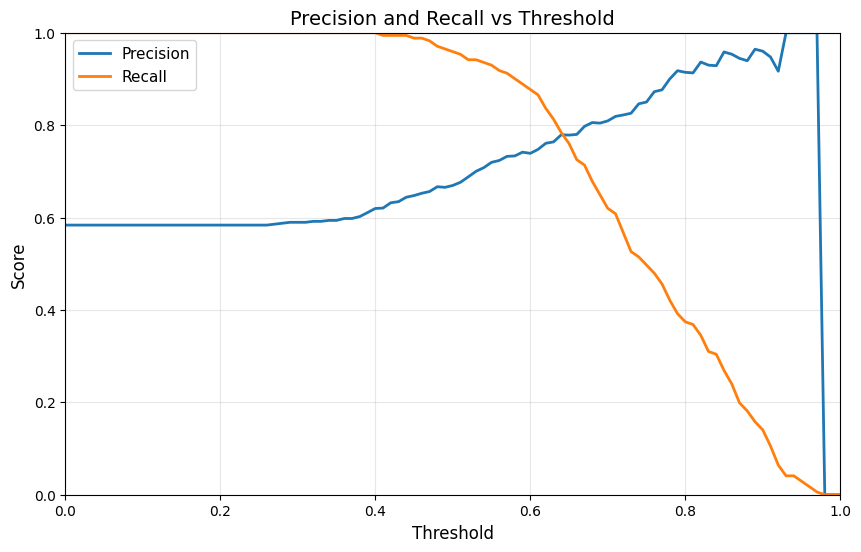


Intersection Point:
Threshold: 0.980
Precision: 0.000
Recall: 0.000
Difference: 0.000000

*** ANSWER: The curves intersect at threshold 0.980 ***

Nearby thresholds:
Threshold: 0.960, Precision: 1.000, Recall: 0.018, Diff: 0.982456
Threshold: 0.970, Precision: 1.000, Recall: 0.006, Diff: 0.994152
Threshold: 0.980, Precision: 0.000, Recall: 0.000, Diff: 0.000000
Threshold: 0.990, Precision: 0.000, Recall: 0.000, Diff: 0.000000
Threshold: 1.000, Precision: 0.000, Recall: 0.000, Diff: 0.000000


In [17]:
from sklearn.metrics import precision_score, recall_score

# Get predicted probabilities on validation set
y_val_pred = model.predict_proba(X_val)[:, 1]

# Evaluate precision and recall at different thresholds
thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []

for threshold in thresholds:
    # Convert probabilities to binary predictions based on threshold
    y_pred_threshold = (y_val_pred >= threshold).astype(int)
    
    # Handle edge cases where all predictions are 0 or 1
    if len(np.unique(y_pred_threshold)) == 1:
        # If all predictions are the same, precision/recall may be undefined
        if y_pred_threshold[0] == 1:
            precision = precision_score(y_val, y_pred_threshold, zero_division=0)
            recall = recall_score(y_val, y_pred_threshold, zero_division=0)
        else:
            precision = 0.0
            recall = 0.0
    else:
        precision = precision_score(y_val, y_pred_threshold, zero_division=0)
        recall = recall_score(y_val, y_pred_threshold, zero_division=0)
    
    precisions.append(precision)
    recalls.append(recall)

# Convert to numpy arrays
precisions = np.array(precisions)
recalls = np.array(recalls)

# Plot precision and recall curves
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', linewidth=2)
plt.plot(thresholds, recalls, label='Recall', linewidth=2)
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Precision and Recall vs Threshold', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

# Find the intersection point
# The intersection occurs where the absolute difference is minimized
differences = np.abs(precisions - recalls)
intersection_idx = np.argmin(differences)
intersection_threshold = thresholds[intersection_idx]
intersection_precision = precisions[intersection_idx]
intersection_recall = recalls[intersection_idx]

print(f"\n{'='*60}")
print(f"Intersection Point:")
print(f"{'='*60}")
print(f"Threshold: {intersection_threshold:.3f}")
print(f"Precision: {intersection_precision:.3f}")
print(f"Recall: {intersection_recall:.3f}")
print(f"Difference: {differences[intersection_idx]:.6f}")
print(f"\n*** ANSWER: The curves intersect at threshold {intersection_threshold:.3f} ***")
print(f"{'='*60}")

# Show nearby thresholds for context
print(f"\nNearby thresholds:")
for i in range(max(0, intersection_idx-2), min(len(thresholds), intersection_idx+3)):
    print(f"Threshold: {thresholds[i]:.3f}, Precision: {precisions[i]:.3f}, Recall: {recalls[i]:.3f}, Diff: {differences[i]:.6f}")

### Question 4: F1 score
    Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both


    Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

    At which threshold F1 is maximal?

    0.14
    0.34
    0.54
    0.74

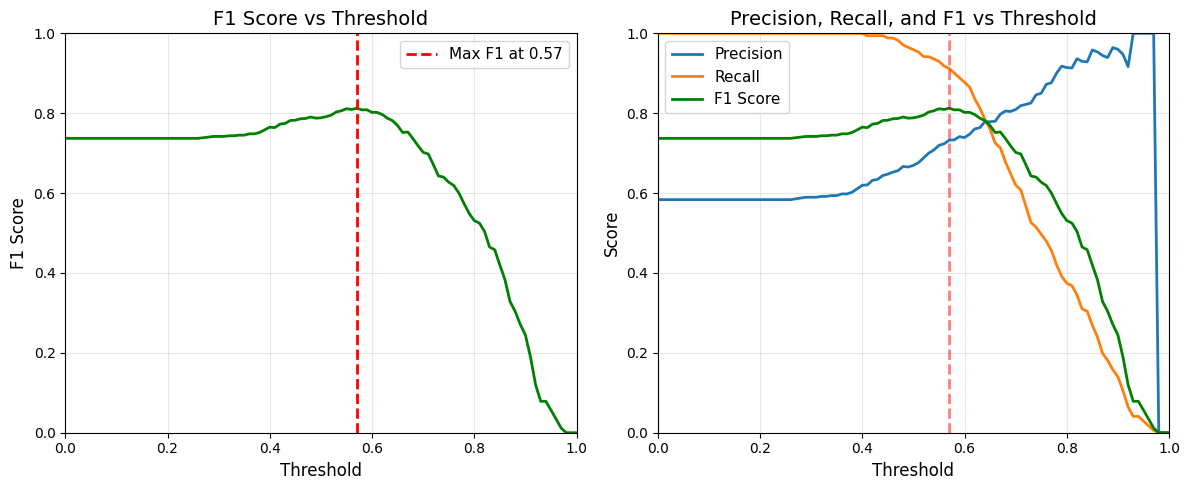


Maximum F1 Score Results:
Threshold: 0.570
F1 Score: 0.812
Precision: 0.732
Recall: 0.912

*** ANSWER: F1 is maximal at threshold 0.57 ***

Nearby thresholds:
Threshold: 0.55, F1: 0.811, Precision: 0.719, Recall: 0.930
Threshold: 0.56, F1: 0.809, Precision: 0.724, Recall: 0.918
Threshold: 0.57, F1: 0.812, Precision: 0.732, Recall: 0.912
Threshold: 0.58, F1: 0.808, Precision: 0.733, Recall: 0.901
Threshold: 0.59, F1: 0.809, Precision: 0.741, Recall: 0.889

Manual F1 verification:
F1 = 2 * 0.732 * 0.912 / (0.732 + 0.912) = 0.812


In [18]:
from sklearn.metrics import f1_score

# Get predicted probabilities on validation set (if not already computed)
y_val_pred = model.predict_proba(X_val)[:, 1]

# Evaluate F1 score at different thresholds
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []
precisions = []
recalls = []

for threshold in thresholds:
    # Convert probabilities to binary predictions based on threshold
    y_pred_threshold = (y_val_pred >= threshold).astype(int)
    
    # Compute F1 score
    f1 = f1_score(y_val, y_pred_threshold, zero_division=0)
    f1_scores.append(f1)
    
    # Also compute precision and recall for plotting
    precision = precision_score(y_val, y_pred_threshold, zero_division=0)
    recall = recall_score(y_val, y_pred_threshold, zero_division=0)
    precisions.append(precision)
    recalls.append(recall)

# Convert to numpy arrays
f1_scores = np.array(f1_scores)
precisions = np.array(precisions)
recalls = np.array(recalls)

# Find the threshold with maximum F1 score
max_f1_idx = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_idx]
max_f1_value = f1_scores[max_f1_idx]
max_f1_precision = precisions[max_f1_idx]
max_f1_recall = recalls[max_f1_idx]

# Plot F1 score vs threshold
plt.figure(figsize=(12, 5))

# Plot 1: F1 score
plt.subplot(1, 2, 1)
plt.plot(thresholds, f1_scores, linewidth=2, color='green')
plt.axvline(x=max_f1_threshold, color='red', linestyle='--', linewidth=2, label=f'Max F1 at {max_f1_threshold:.2f}')
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('F1 Score vs Threshold', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])

# Plot 2: Precision, Recall, and F1 together
plt.subplot(1, 2, 2)
plt.plot(thresholds, precisions, label='Precision', linewidth=2)
plt.plot(thresholds, recalls, label='Recall', linewidth=2)
plt.plot(thresholds, f1_scores, label='F1 Score', linewidth=2, color='green')
plt.axvline(x=max_f1_threshold, color='red', linestyle='--', linewidth=2, alpha=0.5)
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Precision, Recall, and F1 vs Threshold', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.tight_layout()
plt.show()

# Display results
print(f"\n{'='*60}")
print(f"Maximum F1 Score Results:")
print(f"{'='*60}")
print(f"Threshold: {max_f1_threshold:.3f}")
print(f"F1 Score: {max_f1_value:.3f}")
print(f"Precision: {max_f1_precision:.3f}")
print(f"Recall: {max_f1_recall:.3f}")
print(f"\n*** ANSWER: F1 is maximal at threshold {max_f1_threshold:.2f} ***")
print(f"{'='*60}")

# Show nearby thresholds for context
print(f"\nNearby thresholds:")
for i in range(max(0, max_f1_idx-2), min(len(thresholds), max_f1_idx+3)):
    print(f"Threshold: {thresholds[i]:.2f}, F1: {f1_scores[i]:.3f}, Precision: {precisions[i]:.3f}, Recall: {recalls[i]:.3f}")

# Verify F1 calculation manually
print(f"\nManual F1 verification:")
if max_f1_precision + max_f1_recall > 0:
    manual_f1 = 2 * max_f1_precision * max_f1_recall / (max_f1_precision + max_f1_recall)
    print(f"F1 = 2 * {max_f1_precision:.3f} * {max_f1_recall:.3f} / ({max_f1_precision:.3f} + {max_f1_recall:.3f}) = {manual_f1:.3f}")

### Question 5: 5-Fold CV
    Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

    KFold(n_splits=5, shuffle=True, random_state=1)
    Iterate over different folds of df_full_train
    Split the data into train and validation
    Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    Use AUC to evaluate the model on validation
    How large is standard deviation of the scores across different folds?

    0.0001
    0.006
    0.06
    0.36

In [19]:
from sklearn.model_selection import KFold


# Use df_full_train (which is the combined train + validation set before the split)
# We need to recreate it or use the original df minus test set
# Let's recreate df_full_train with the target variable

# Reconstruct full_train by combining df_train and df_val with their targets
df_full_train_reconstructed = pd.concat([
    df_train.assign(converted=y_train),
    df_val.assign(converted=y_val)
], axis=0).reset_index(drop=True)

print(f"df_full_train shape: {df_full_train_reconstructed.shape}")
print(f"Target distribution: {df_full_train_reconstructed['converted'].value_counts()}")

# Initialize KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

# Store AUC scores for each fold
auc_scores = []

print(f"\n{'='*60}")
print("5-Fold Cross-Validation Results:")
print(f"{'='*60}")

# Iterate over folds
for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(df_full_train_reconstructed), 1):
    # Split the data
    df_train_fold = df_full_train_reconstructed.iloc[train_idx].copy()
    df_val_fold = df_full_train_reconstructed.iloc[val_idx].copy()
    
    # Extract targets
    y_train_fold = df_train_fold['converted'].values
    y_val_fold = df_val_fold['converted'].values
    
    # Remove target from features
    df_train_fold = df_train_fold.drop('converted', axis=1)
    df_val_fold = df_val_fold.drop('converted', axis=1)
    
    # Fill missing values (in case there are any)
    for col in df_train_fold.select_dtypes(include=['object']).columns:
        df_train_fold[col] = df_train_fold[col].fillna('NA')
        df_val_fold[col] = df_val_fold[col].fillna('NA')
    
    for col in df_train_fold.select_dtypes(include=['number']).columns:
        df_train_fold[col] = df_train_fold[col].fillna(0.0)
        df_val_fold[col] = df_val_fold[col].fillna(0.0)
    
    # Convert to dictionaries
    train_dicts_fold = df_train_fold.to_dict(orient='records')
    val_dicts_fold = df_val_fold.to_dict(orient='records')
    
    # Apply one-hot encoding
    dv_fold = DictVectorizer(sparse=False)
    X_train_fold = dv_fold.fit_transform(train_dicts_fold)
    X_val_fold = dv_fold.transform(val_dicts_fold)
    
    # Train the model
    model_fold = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model_fold.fit(X_train_fold, y_train_fold)
    
    # Predict on validation set
    y_val_pred_fold = model_fold.predict_proba(X_val_fold)[:, 1]
    
    # Calculate AUC
    auc_fold = roc_auc_score(y_val_fold, y_val_pred_fold)
    auc_scores.append(auc_fold)
    
    print(f"Fold {fold_idx}: AUC = {auc_fold:.4f}")

# Convert to numpy array
auc_scores = np.array(auc_scores)

# Calculate statistics
mean_auc = auc_scores.mean()
std_auc = auc_scores.std()

print(f"\n{'='*60}")
print("Cross-Validation Statistics:")
print(f"{'='*60}")
print(f"AUC scores: {auc_scores}")
print(f"Mean AUC: {mean_auc:.4f}")
print(f"Standard Deviation: {std_auc:.4f}")
print(f"\n*** ANSWER: Standard deviation = {std_auc:.3f} ***")
print(f"{'='*60}")

# Determine which option is closest
options = [0.0001, 0.006, 0.06, 0.36]
closest_option = min(options, key=lambda x: abs(x - std_auc))
print(f"\nClosest option: {closest_option}")

df_full_train shape: (1169, 9)
Target distribution: converted
1    715
0    454
Name: count, dtype: int64

5-Fold Cross-Validation Results:
Fold 1: AUC = 0.8180
Fold 2: AUC = 0.8035
Fold 3: AUC = 0.8425
Fold 4: AUC = 0.8024
Fold 5: AUC = 0.8448

Cross-Validation Statistics:
AUC scores: [0.81804734 0.8034964  0.84252269 0.80235562 0.84476087]
Mean AUC: 0.8222
Standard Deviation: 0.0183

*** ANSWER: Standard deviation = 0.018 ***

Closest option: 0.006


### Question 6: Hyperparameter Tuning
    Now let's use 5-Fold cross-validation to find the best parameter C

    Iterate over the following C values: [0.000001, 0.001, 1]
    Initialize KFold with the same parameters as previously
    Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
    Which C leads to the best mean score?

    0.000001
    0.001
    1
    If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

In [20]:

# C values to test
C_values = [0.000001, 0.001, 1]

# Store results for each C
results = []

print(f"\n{'='*70}")
print("Hyperparameter Tuning with 5-Fold Cross-Validation")
print(f"{'='*70}\n")

# Iterate over C values
for C in C_values:
    print(f"Testing C = {C}")
    print(f"-" * 70)
    
    # Initialize KFold
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    
    # Store AUC scores for each fold
    auc_scores = []
    
    # Iterate over folds
    for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(df_full_train_reconstructed), 1):
        # Split the data
        df_train_fold = df_full_train_reconstructed.iloc[train_idx].copy()
        df_val_fold = df_full_train_reconstructed.iloc[val_idx].copy()
        
        # Extract targets
        y_train_fold = df_train_fold['converted'].values
        y_val_fold = df_val_fold['converted'].values
        
        # Remove target from features
        df_train_fold = df_train_fold.drop('converted', axis=1)
        df_val_fold = df_val_fold.drop('converted', axis=1)
        
        # Fill missing values
        for col in df_train_fold.select_dtypes(include=['object']).columns:
            df_train_fold[col] = df_train_fold[col].fillna('NA')
            df_val_fold[col] = df_val_fold[col].fillna('NA')
        
        for col in df_train_fold.select_dtypes(include=['number']).columns:
            df_train_fold[col] = df_train_fold[col].fillna(0.0)
            df_val_fold[col] = df_val_fold[col].fillna(0.0)
        
        # Convert to dictionaries
        train_dicts_fold = df_train_fold.to_dict(orient='records')
        val_dicts_fold = df_val_fold.to_dict(orient='records')
        
        # Apply one-hot encoding
        dv_fold = DictVectorizer(sparse=False)
        X_train_fold = dv_fold.fit_transform(train_dicts_fold)
        X_val_fold = dv_fold.transform(val_dicts_fold)
        
        # Train the model with current C
        model_fold = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model_fold.fit(X_train_fold, y_train_fold)
        
        # Predict on validation set
        y_val_pred_fold = model_fold.predict_proba(X_val_fold)[:, 1]
        
        # Calculate AUC
        auc_fold = roc_auc_score(y_val_fold, y_val_pred_fold)
        auc_scores.append(auc_fold)
        
        print(f"  Fold {fold_idx}: AUC = {auc_fold:.4f}")
    
    # Convert to numpy array
    auc_scores = np.array(auc_scores)
    
    # Calculate statistics
    mean_auc = np.round(auc_scores.mean(), 3)
    std_auc = np.round(auc_scores.std(), 3)
    
    results.append({
        'C': C,
        'mean_auc': mean_auc,
        'std_auc': std_auc,
        'scores': auc_scores
    })
    
    print(f"  Mean AUC: {mean_auc:.3f} ± {std_auc:.3f}")
    print()

# Display summary table
print(f"{'='*70}")
print("Summary of Results:")
print(f"{'='*70}")
print(f"{'C':<15} {'Mean AUC':<15} {'Std AUC':<15}")
print(f"-" * 70)

for result in results:
    print(f"{result['C']:<15} {result['mean_auc']:<15.3f} {result['std_auc']:<15.3f}")

# Find the best C
# Sort by: 1) highest mean_auc, 2) lowest std_auc, 3) smallest C
results_sorted = sorted(results, key=lambda x: (-x['mean_auc'], x['std_auc'], x['C']))

best_result = results_sorted[0]

print(f"\n{'='*70}")
print("Best Result:")
print(f"{'='*70}")
print(f"Best C: {best_result['C']}")
print(f"Mean AUC: {best_result['mean_auc']:.3f}")
print(f"Std AUC: {best_result['std_auc']:.3f}")
print(f"\n*** ANSWER: C = {best_result['C']} leads to the best mean score ***")
print(f"{'='*70}")

# Check for ties in mean_auc
best_mean = best_result['mean_auc']
tied_results = [r for r in results if r['mean_auc'] == best_mean]

if len(tied_results) > 1:
    print(f"\nNote: There are {len(tied_results)} C values with the same mean AUC of {best_mean:.3f}")
    print("Tie-breaking by std, then by smallest C:")
    for r in tied_results:
        print(f"  C = {r['C']}, Mean = {r['mean_auc']:.3f}, Std = {r['std_auc']:.3f}")


Hyperparameter Tuning with 5-Fold Cross-Validation

Testing C = 1e-06
----------------------------------------------------------------------
  Fold 1: AUC = 0.5804
  Fold 2: AUC = 0.5751
  Fold 3: AUC = 0.5199
  Fold 4: AUC = 0.6251
  Fold 5: AUC = 0.5070
  Mean AUC: 0.561 ± 0.043

Testing C = 0.001
----------------------------------------------------------------------
  Fold 1: AUC = 0.8591
  Fold 2: AUC = 0.8448
  Fold 3: AUC = 0.8877
  Fold 4: AUC = 0.8614
  Fold 5: AUC = 0.8798
  Mean AUC: 0.867 ± 0.015

Testing C = 1
----------------------------------------------------------------------
  Fold 1: AUC = 0.8180
  Fold 2: AUC = 0.8035
  Fold 3: AUC = 0.8425
  Fold 4: AUC = 0.8024
  Fold 5: AUC = 0.8448
  Mean AUC: 0.822 ± 0.018

Summary of Results:
C               Mean AUC        Std AUC        
----------------------------------------------------------------------
1e-06           0.561           0.043          
0.001           0.867           0.015          
1               0.822  